In [1]:
#!pip install bertopic #Kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 kB 350.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp37-cp37m-linux_x86_64.whl size=3426764 sha256=1e95685a51a0a4fe2e52065f332408652b8e9b0ba88cb02698519afb748b2ce3
  Stored in directory: /root/.cache/pip/wheels/93/78/2e/03ee191669a772e9653260aa3bd53e0b1a768751a9676e8c82
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e68464629ae727e60d85ab01e1c83a6be4bfdf00e3a07e

In [2]:
#conda install -c conda-forge spacy-model-en_core_web_md #Kaggle

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

import spacy
import en_core_web_md

import nltk
from nltk.tokenize import wordpunct_tokenize, word_tokenize, WhitespaceTokenizer
from nltk.corpus import stopwords, wordnet

from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax

from wordcloud import WordCloud
from collections import defaultdict

In [4]:
df_fake_all = pd.read_csv("/kaggle/input/misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_FAKE.csv")
df_true_all = pd.read_csv("/kaggle/input/misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_TRUE.csv")

In [5]:
df_fake_all['label'] = 0
df_true_all['label'] = 1

df_fake_all = df_fake_all.drop('Unnamed: 0', axis=1)
df_true_all = df_true_all.drop('Unnamed: 0', axis=1)

df_fake = df_fake_all.drop_duplicates().reset_index(drop=True)
df_true = df_true_all.drop_duplicates().reset_index(drop=True)

# Data Analysis
---
---

In [6]:
def plotBarChart(number, d, title):
    sorted_dict = sorted(d.items(), key=lambda x:x[1], reverse=True)
    sub_sorted_dict = dict(list(sorted_dict)[:number])

    keys = sub_sorted_dict.keys()
    values = sub_sorted_dict.values()

    plt.bar(keys, values, color=['#78aac3', '#c4deee', '#97c8d6', '#eeab73', '#f3cd86', '#f5a281'])
    plt.title(title)
    ax = plt.gca()
    ax.set_ylabel('Count')
    plt.xticks(rotation = 30)
    plt.show()

In [7]:
def plotHist(d, title):
    plt.hist(d, color='#78aac3', range=[0, 4500])
    plt.title(title)
    ax = plt.gca()
    ax.set_xlabel('# Words')
    ax.set_ylabel('# Articles')
    plt.show()

### Word count comparison (w/o preprocessing)
---

In [8]:
tk = WhitespaceTokenizer()

df_fake['text'] = df_fake['text'].apply(str)
df_true['text'] = df_true['text'].apply(str)

df_fake['words'] = df_fake.apply(lambda row: len(tk.tokenize(row['text'])), axis=1)
df_true['words'] = df_true.apply(lambda row: len(tk.tokenize(row['text'])), axis=1)

#### -- FAKE --

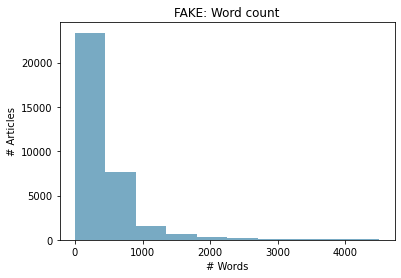

In [9]:
plotHist(df_fake['words'], 'FAKE: Word count')

In [10]:
df_fake.describe()

,label,words
count,34078.0,34078.000000
mean,0.0,426.675685
std,0.0,625.342871
min,0.0,1.000000
25%,0.0,97.000000
50%,0.0,331.000000
75%,0.0,509.000000
max,0.0,24234.000000


#### ++ TRUE ++

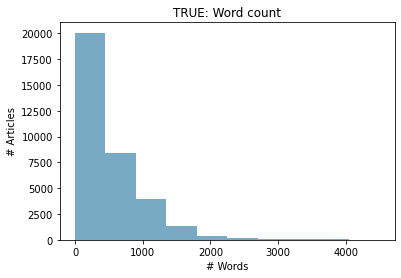

In [11]:
plotHist(df_true['words'], 'TRUE: Word count')

In [12]:
df_true.describe()

,label,words
count,34527.0,34527.000000
mean,1.0,537.141773
std,0.0,567.221873
min,1.0,1.000000
25%,1.0,181.000000
50%,1.0,391.000000
75%,1.0,724.500000
max,1.0,14641.000000


### Most frequent named entities (w/o stopwords)
---

In [13]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_md', exclude=['tagger', 'parser', 'attribute_ruler', 'lemmatizer'])

In [14]:
clinton = ['hillary', 'hillary clinton']
trump = ['donald','donald trump', 'donald j. trump']
obama = ['barack', 'barack obama']
comey = ['james comey']
sanders = ['bernie sanders']
putin = ['vladimir putin']
us = ['us', 'u.s.', 'the united states']
white_house = ['white house']

In [15]:
def removeStopwords(text):
    all_tokens = ""
    tokens = word_tokenize(text)
    
    for token in tokens:
        token_low = token.lower()
        
        if token_low not in stop_words: 
            all_tokens = all_tokens + token_low + " "
    
    return all_tokens

In [16]:
def semanticDuplicate(word):
    word_low = word.lower()
    
    if word_low in us:
        return 'U.S.'
    elif word_low in clinton:
        return 'Clinton'
    elif word_low in trump:
        return 'Trump'
    elif word_low in obama:
        return 'Obama'
    elif word_low in comey:
        return 'Comey'
    elif word_low in sanders:
        return 'Sanders'
    elif word_low in putin:
        return 'Putin'
    elif word_low in white_house:
        return 'the White House'
    
    return word

#### -- FAKE --

In [17]:
df_fake['text_wo_stopwords'] = df_fake.apply(lambda row: removeStopwords(row['text']), axis=1)

In [18]:
dict_fake_PERSON = defaultdict(int)
dict_fake_ORG = defaultdict(int)
dict_fake_GPE = defaultdict(int)

for idx in range(0, len(df_fake)):
    text = nlp(df_fake.iloc[idx]['text'])

    for word in text.ents:
        new_word = semanticDuplicate(word.text)
        
        if word.label_ == 'PERSON':
            dict_fake_PERSON[new_word] += 1
        elif word.label_ == 'ORG':
            dict_fake_ORG[new_word] += 1
        elif word.label_ == 'GPE':
            dict_fake_GPE[new_word] += 1

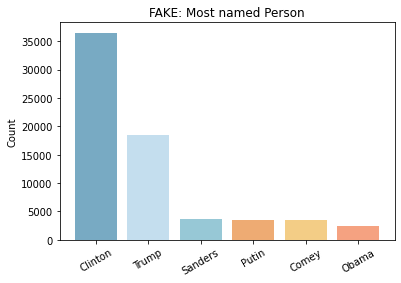

In [19]:
plotBarChart(6, dict_fake_PERSON, "FAKE: Most named Person")

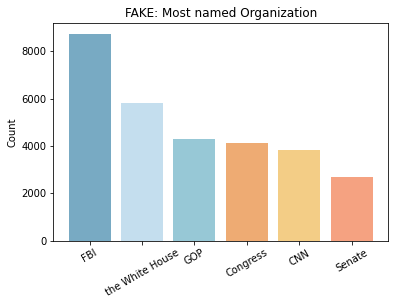

In [20]:
plotBarChart(6, dict_fake_ORG, "FAKE: Most named Organization")

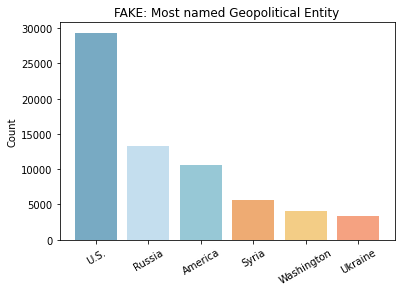

In [21]:
plotBarChart(6, dict_fake_GPE, "FAKE: Most named Geopolitical Entity")

#### ++ TRUE ++

In [22]:
df_true['text_wo_stopwords'] = df_true.apply(lambda row: removeStopwords(row['text']), axis=1)

In [23]:
dict_true_PERSON = defaultdict(int)
dict_true_ORG = defaultdict(int)
dict_true_GPE = defaultdict(int)

for idx in range(0, len(df_true)):
    text = nlp(df_true.iloc[idx]['text'])

    for word in text.ents:
        new_word = semanticDuplicate(word.text)
        
        if word.label_ == 'PERSON':
            dict_true_PERSON[new_word] += 1
        elif word.label_ == 'ORG':
            dict_true_ORG[new_word] += 1
        elif word.label_ == 'GPE':
            dict_true_GPE[new_word] += 1

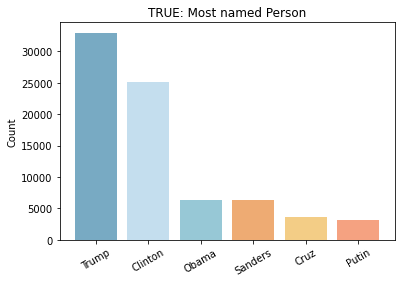

In [24]:
plotBarChart(6, dict_true_PERSON, "TRUE: Most named Person")

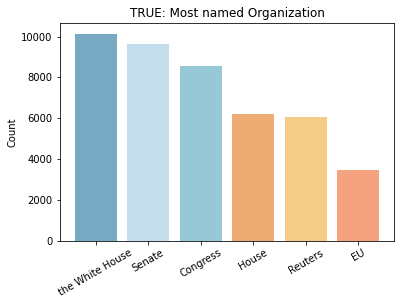

In [25]:
plotBarChart(6, dict_true_ORG, "TRUE: Most named Organization")

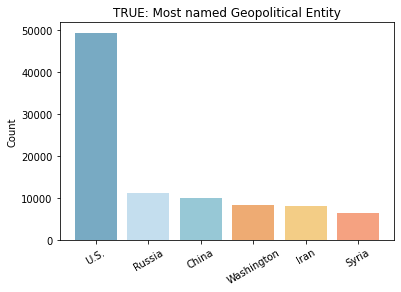

In [26]:
plotBarChart(6, dict_true_GPE, "TRUE: Most named Geopolitical Entity")

### Most frequent words (w/o stopwords & punctuation)
---

In [27]:
punctuations = list(string.punctuation)

In [28]:
def removePunctuation(text, d):
    all_tokens = ""
    tokens = wordpunct_tokenize(text)
    
    for token in tokens: 
        token_tmp = ""

        for char in token:
            if char in punctuations:
                continue

            token_tmp += char

        if len(token_tmp) < 3:
            continue

        token_low = token.lower()
        
        if token_low not in stop_words: 
            d[token_low] += 1
            all_tokens = all_tokens + token_low + " "
    
    return all_tokens

#### -- FAKE --

In [29]:
dict_fake_freq = defaultdict(int)

df_fake['text_wo_punctuation'] = df_fake.apply(lambda row: removePunctuation(row['text_wo_stopwords'], dict_fake_freq), axis=1)

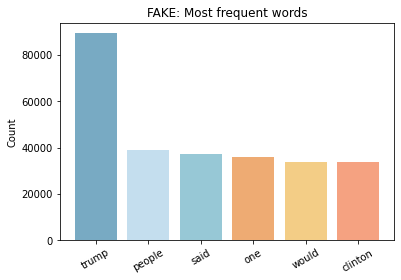

In [30]:
plotBarChart(6, dict_fake_freq, "FAKE: Most frequent words")

#### ++ TRUE ++

In [31]:
dict_true_freq = defaultdict(int)

df_true['text_wo_punctuation'] = df_true.apply(lambda row: removePunctuation(row['text_wo_stopwords'], dict_true_freq), axis=1)

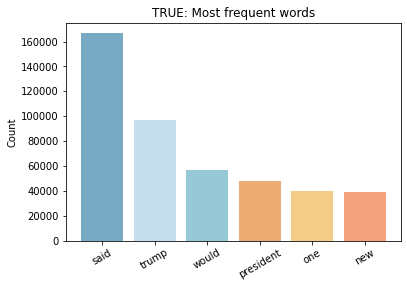

In [32]:
plotBarChart(6, dict_true_freq, "TRUE: Most frequent words")

### Word clouds
---

In [33]:
def plotWordClouds(df):
    full_string = ','.join(list(df['text_wo_punctuation'].values))
    
    wordcloud = WordCloud(width=1000, height=1000, max_words=500, background_color="white").generate(full_string)
    
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()  

#### -- FAKE --

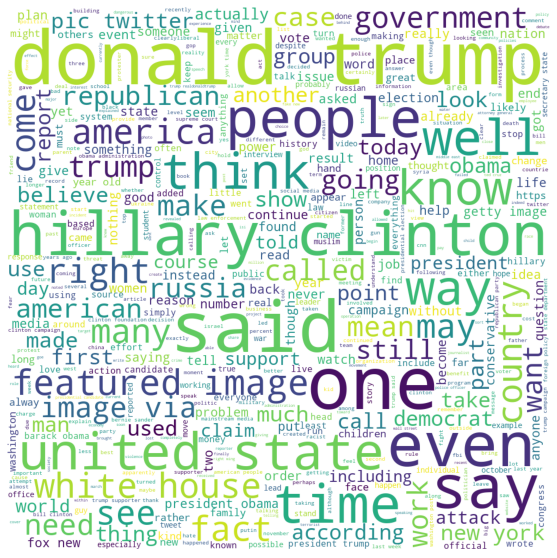

In [34]:
plotWordClouds(df_fake)

#### ++ TRUE ++

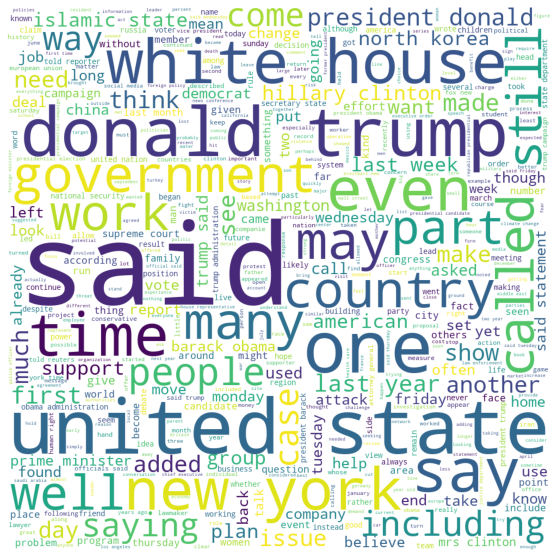

In [35]:
plotWordClouds(df_true)

### Topic clusters with BERTopic
---

In [36]:
def createTopicCluster(df):
    full_string = list(df.values)
    
    topic_model = BERTopic(embedding_model = nlp, calculate_probabilities = True)
    topics, probs = topic_model.fit_transform(full_string)
    return topic_model, topics, probs

#### -- FAKE --

In [37]:
topic_model_fake, topics_fake, probs_fake = createTopicCluster(df_fake['text_wo_punctuation'])
fig_fake = topic_model_fake.visualize_topics()
fig_fake.show()

In [38]:
topic_model_fake.get_topic_info()

,Topic,Count,Name
0,-1,21054,-1_trump_people_said_president
1,0,1223,0_fbi_emails_comey_clinton
2,1,876,1_vote_voting_election_voter
3,2,663,2_mosul_syrian_aleppo_syria
4,3,503,3_cancer_disease_vaccine_health
...,...,...,...
260,259,10,259_snyder_flint_governor_nail
261,260,10,260_veterans_money_moonves_hats
262,261,10,261_bash_hotel_obamacare_opening
263,262,10,262_soviet_belarus_lukashenka_ribbentrop


#### ++ TRUE ++

In [39]:
topic_model_true, topics_true, probs_true = createTopicCluster(df_true['text_wo_punctuation'])
fig_true = topic_model_true.visualize_topics()
fig_true.show()

In [40]:
topic_model_true.get_topic_info()

,Topic,Count,Name
0,-1,17114,-1_trump_said_people_would
1,0,1038,0_korea_north_china_missile
2,1,846,1_intelligence_comey_russian_russia
3,2,617,2_russia_russian_putin_moscow
4,3,510,3_obamacare_bill_healthcare_senate
...,...,...,...
280,279,10,279_checkers_nye_wakeman_kia
281,280,10,280_goldman_cohn_mnuchin_sachs
282,281,10,281_bataclan_france_stade_paris
283,282,10,282_airlines_airways_passengers_etihad


### Sentiment Analysis - Positive, Negative, Neutral
---

In [41]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

sentiment_tokenizer = AutoTokenizer.from_pretrained(MODEL)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(MODEL)
sentiment_model.save_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [42]:
def getScores(text):
    input_tensor = sentiment_tokenizer(text, truncation=True, max_length=512, return_tensors='pt')
    output = sentiment_model(**input_tensor)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

In [43]:
def plotScores(values, title):
    keys = ['Negative', 'Neutral', 'Positive']
    plt.bar(keys, values, color=['#f5a281','#f3cd86','#78aac3'])
    plt.title(title)
    ax = plt.gca()
    ax.set_ylabel('%')
    plt.show()

In [44]:
samples = 500

#### -- FAKE --

In [45]:
total_fake_scores = np.zeros(3)

df_fake_shuffled = df_fake.sample(frac = 1)
df_fake_subset = df_fake_shuffled[:samples]

for idx in range(0, len(df_fake_subset)):
    fake_text = df_fake_subset.iloc[idx]['text']
    fake_score = getScores(fake_text)
    total_fake_scores += np.array(fake_score)
    
print(total_fake_scores / samples)    

[0.5204177  0.38481445 0.09476784]


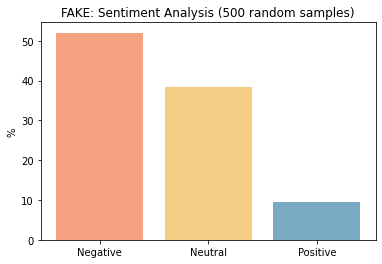

In [46]:
fake_values = total_fake_scores / samples * 100
plotScores(fake_values, 'FAKE: Sentiment Analysis (500 random samples)')

---

#### ++ TRUE ++

In [47]:
total_true_scores = np.zeros(3)

df_true_shuffled = df_true.sample(frac = 1)
df_true_subset = df_true_shuffled[:samples]

for idx in range(0, len(df_true_subset)):
    true_text = df_true.iloc[idx]['text']
    true_score = getScores(true_text)
    total_true_scores += np.array(true_score)
    
print(total_true_scores / samples)    

[0.26982591 0.58952891 0.14064518]


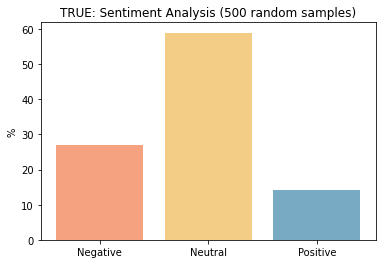

In [48]:
true_values = total_true_scores / samples * 100
plotScores(true_values, 'TRUE: Sentiment Analysis (500 random samples)')

### Sentiment Analysis - Emotion
---

In [49]:
MODEL_E = "bhadresh-savani/distilbert-base-uncased-emotion"
classifier = pipeline("text-classification",model=MODEL_E, truncation=True, max_length=512, return_all_scores=True)

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

2023-01-09 18:45:08.601180: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [50]:
def getEmotionScores(text):
    emotions = np.zeros(0)
    prediction = classifier(text,)
    df_pred = pd.DataFrame.from_dict(prediction)
    return np.array(df_pred.score)

In [51]:
def plotEmotionScores(values, title):
    keys = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    plt.bar(keys, values, color=['#78aac3', '#c4deee', '#97c8d6', '#eeab73', '#f3cd86', '#f5a281'])
    plt.title(title)
    ax = plt.gca()
    ax.set_ylabel('%')
    plt.show()

#### -- FAKE --

In [52]:
total_fake_emotions = np.zeros(6)

for idx in range(0, len(df_fake_subset)):
    fake_text = df_fake_subset.iloc[idx]['text']
    fake_emotion = getEmotionScores(fake_text)
    total_fake_emotions += fake_emotion

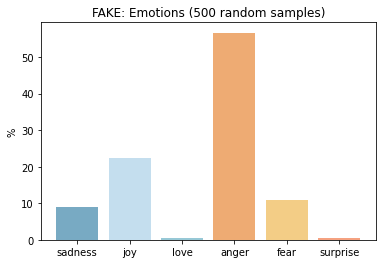

In [53]:
fake_emotion_values = total_fake_emotions / samples * 100
plotEmotionScores(fake_emotion_values, 'FAKE: Emotions (500 random samples)')

#### ++ TRUE ++

In [54]:
total_true_emotions = np.zeros(6)

for idx in range(0, len(df_true_subset)):
    true_text = df_true_subset.iloc[idx]['text']
    true_emotion = getEmotionScores(true_text)
    total_true_emotions += true_emotion

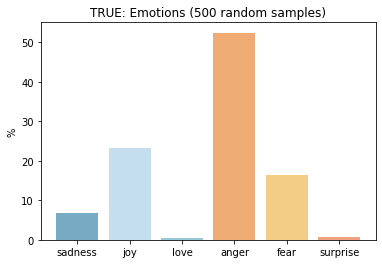

In [55]:
true_emotion_values = total_true_emotions / samples * 100
plotEmotionScores(true_emotion_values, 'TRUE: Emotions (500 random samples)')

---
---